In [1]:
import math
import random
import ssl
import urllib.request
from random import sample

import certifi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
from tensorboard.notebook import display
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm
from tqdm.auto import tqdm

from deviceUtility import get_best_available_device
from plot_utility import get_distribution

# Fix SSL certificate issue
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))
gpu = get_best_available_device()

________________________

Device manager:
Running on device: mps
________________________


/Users/Admin/PycharmProjects/python_leetcode/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
TIME_STEP = 1000
EPOCH_NUM = 20
LEARNING_RATE = 1e-4

BETA_START = 1e-4
BETA_END = 0.02

BATCH_SIZE = 32

### Precalculations

#### Variance Scheduler

In [3]:
def cosine_beta_scheduler(steps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = steps + 1
    x = torch.linspace(0, steps, steps, device=gpu)
    alphas_cum_prod = torch.cos(((x / steps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cum_prod = alphas_cum_prod / alphas_cum_prod[0]
    betas = 1 - (alphas_cum_prod[1:] / alphas_cum_prod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

In [4]:
betas = torch.linspace(BETA_START, BETA_END, TIME_STEP,
                       device=gpu)  #cosine_beta_scheduler(TIME_STEP)# # Linear Variance Scheduler
alphas = 1. - betas
alphas_cum_prod = torch.cumprod(alphas, 0)
alphas_cum_prod_prev = F.pad(alphas_cum_prod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cum_prod = torch.sqrt(alphas_cum_prod)
sqrt_one_minus_alphas_cum_prod = torch.sqrt(1. - alphas_cum_prod)
posterior_variance = betas * (1. - alphas_cum_prod_prev) / (1. - alphas_cum_prod)

### Helper functions

In [5]:
def extract(equation, timestep, x_shape):
    """
    Extracts the values of the equation for the given timestep for every image in the batch.
    """
    size = timestep.shape[0]
    out = equation.gather(-1, timestep.to(gpu))
    return out.reshape(size, *((1,) * (len(x_shape) - 1))).to(timestep.device)


def q_sample(image_batch, timestep, noise=None):
    """
    Forward pass of the diffusion model.
    Adds noise to an image at time t.
    If noise is not provided, it is sampled from a standard normal distribution.
    """
    if noise is None:
        noise = torch.randn_like(image_batch)

    # Extract the values for every image in the batch for the given timestep
    sqrt_alphas_cum_prod_t = extract(sqrt_alphas_cum_prod, timestep, image_batch.shape)
    sqrt_one_minus_alphas_cum_prod_t = extract(sqrt_one_minus_alphas_cum_prod, timestep, image_batch.shape)

    return sqrt_alphas_cum_prod_t * image_batch + sqrt_one_minus_alphas_cum_prod_t * noise


@torch.no_grad()
def p_sample(model, x, t, t_index, condition, guidance_Weight=0.5):
    """
    Reverse pass of the diffusion model.
    Given an image at time t, it predicts the image at time t-1.
    """
    condition = condition.to(gpu)
    betas_t = extract(betas, t, x.shape)

    sqrt_one_minus_alphas_cum_prod_t = extract(
        sqrt_one_minus_alphas_cum_prod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean_unconditional = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cum_prod_t)

    model_mean_conditional = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t, condition) / sqrt_one_minus_alphas_cum_prod_t)

    model_mean_guided = (1 + guidance_Weight) * model_mean_conditional - guidance_Weight * model_mean_unconditional

    if t_index == 0:
        return model_mean_guided
    else:
        """
        Helps determine amount of noise to remove from the image.
        """
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean_guided + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model, shape, conditionals):
    device = gpu
    b = shape[0]
    conditionals.to(gpu)
    img = torch.randn(shape, device=device)  # Random noised image

    for i in tqdm(reversed(range(0, TIME_STEP)), desc='Sampling loop time step.', total=TIME_STEP):
        img = p_sample(model=model, x=img, t=torch.full((b,), i, device=device, dtype=torch.long), t_index=i,condition=conditionals)
    return img


def p_losses(denoise_model, x_start, timestep, conditionals, noise=None, loss_type="l1"):
    # If noise is not provided, create noise similar to the input image
    if noise is None:
        noise = torch.randn_like(x_start)

    # Input image with the random noise and the timestep
    x_noisy = q_sample(x_start, timestep, noise)

    # Feed the noisy image to the denoise model to predict the noise
    predicted_noise = denoise_model(x_noisy, timestep, conditionals)

    # Calculate the loss between the predicted noise and the actual noise
    if loss_type == 'l1':
        model_loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        model_loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        model_loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return model_loss


### Sinusoidal Positional Embedding
As parameter of neural network are 
shared across time one should employ 
a sinusoidal embedding to encode the position of the input. 
Makes the neural network know which timestep it is at.

In [6]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # Create a sinusoidal embedding for each position in time
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=gpu) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb.to(gpu)

### Convolutional Layer
Classes which define the building blocks of the UNet architecture.
Consists of double convolutional layers with ReLU activation functions.
Also includes a time embedding layer which is added to the output of the first convolutional layer.

In [7]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super(Block, self).__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, out_channels),
            nn.ReLU(inplace=True)
        )

        self.condition_emb = nn.Sequential(
            nn.Linear(10, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, t, c=None):
        # First convolution
        h = self.relu(self.conv1(x))

        # Compute time embedding and reshape to match spatial dimensions
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)

        # Add time embedding
        h = h + time_emb

        if isinstance(c, torch.Tensor):
            cemb = self.condition_emb(c).to(gpu)
        
            cemb = cemb[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)
            h = h + cemb

        # Second convolution
        h = self.relu(self.conv2(h))
        return h

### U-net
The UNet architecture for approximating the means of the posterior distribution.
The architecture consists of a contracting path, a bottleneck, and an expanding path.

In [8]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.time_emb_dim = 32
        self.max_pool = nn.MaxPool2d(2, 2)

        # Contracting path
        self.encoder1 = Block(1, 64, self.time_emb_dim)
        self.encoder2 = Block(64, 128, self.time_emb_dim)

        # Bottleneck
        self.bottleneck = Block(128, 256, self.time_emb_dim)

        # Expanding path
        self.up_convolution_3 = nn.ConvTranspose2d(256, 128, kernel_size=2,
                                                   stride=2)
        self.up_convolution_4 = nn.ConvTranspose2d(128, 64, kernel_size=2,
                                                   stride=2)

        self.decoder3 = Block(256, 128, self.time_emb_dim)
        self.decoder4 = Block(128, 64, self.time_emb_dim)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t, c=None):
        # Contracting path
        enc1_out = self.encoder1(x, t, c)
        pool_enc1_out = self.max_pool(enc1_out)

        enc2_out = self.encoder2(pool_enc1_out, t, c)
        pool_enc2_out = self.max_pool(enc2_out)

        # Bottleneck
        bottle_out = self.bottleneck(pool_enc2_out, t, c)

        # Expanding path, sees på...
        up_conv_3_out = self.up_convolution_3(bottle_out)
        crop_up_conv_3_out = crop_tensor(enc2_out, up_conv_3_out)
        dec3_out = self.decoder3(
            torch.cat([up_conv_3_out, crop_up_conv_3_out], dim=1), t, c)

        up_conv_4_out = self.up_convolution_4(dec3_out)
        crop_up_conv_4_out = crop_tensor(enc1_out, up_conv_4_out)
        dec4_out = self.decoder4(
            torch.cat([up_conv_4_out, crop_up_conv_4_out], dim=1), t, c)

        output = self.output_layer(dec4_out)

        return output


def crop_tensor(tensor, target_tensor):
    """Make the tensor the same size as the target tensor by cropping."""
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_h = (tensor_size[0] - target_size[0]) // 2
    delta_w = (tensor_size[1] - target_size[1]) // 2
    return tensor[:, :, delta_h:tensor_size[0] - delta_h,
           delta_w:tensor_size[1] - delta_w]

### Load data

In [9]:
image_size = 28
channels = 1  # Grey scale

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),  # Said in paper to help with training
     transforms.ToTensor(),
     transforms.Lambda(lambda x: (x * 2) - 1),  # Normalize to [-1, 1]
     ]
)

mnist = MNIST(root='.', train=True, download=True, transform=transform)

dataloader = DataLoader(mnist, batch_size=BATCH_SIZE, shuffle=True, )

### Training model


In [10]:
# Train model
model = UNet().to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

with tqdm(range(0, EPOCH_NUM), desc="Epochs", total=EPOCH_NUM) as epoch_progress:
    for epoch in epoch_progress:
        for step, (batch, c) in enumerate(dataloader):  # Iterate over every batch in the dataloader

            # Convert the labels to one-hot encoding half of the time. 
            if random.random() < 0.5:
                c = nn.functional.one_hot(c, num_classes=10).float()
            else:
                c = torch.zeros_like(nn.functional.one_hot(c, num_classes=10).float())
            optimizer.zero_grad()

            # Get the batch size and move the batch to the device
            batch_size = batch.shape[0]
            batch = batch.to(gpu)

            # Algorithm 1 line 3: sample t uniformly for every example in the batch
            t = torch.randint(0, TIME_STEP, (batch_size,), device=gpu).long()
            c = c.to(gpu)
            loss = p_losses(model, batch, t, conditionals=c)

            # If the step is a multiple of 100, print the loss
            if step % 100 == 0:
                epoch_progress.set_postfix(loss=loss.item())

            # Algorithm 1 line 5: backpropagate the loss
            loss.backward()

            # Algorithm 1 line 6: update the weights
            optimizer.step()

Epochs: 100%|██████████| 20/20 [19:36<00:00, 58.81s/it, loss=0.0551]


### Generate images

Sampling loop time step.: 100%|██████████| 1000/1000 [00:16<00:00, 59.45it/s]


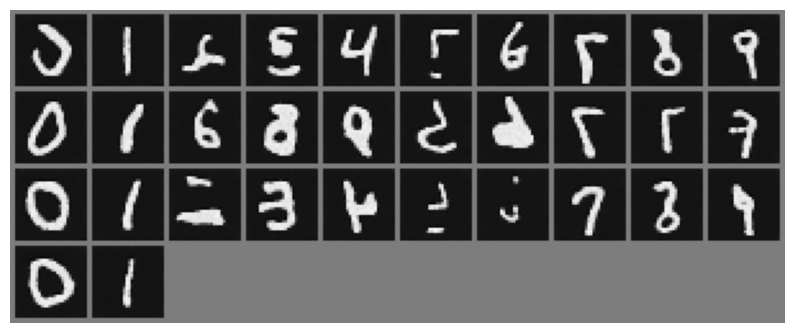

In [16]:
numbers = torch.tensor([0,1,2,3,4,5,6,7,8,9, 0,1,2,3,4,5,6,7,8,9, 0,1,2,3,4,5,6,7,8,9, 0,1])
numbers = nn.functional.one_hot(numbers, num_classes=10)
numbers = numbers.type(torch.float32)
numbers.to(gpu)

samples = p_sample_loop(model, shape=(BATCH_SIZE, channels, image_size, image_size), conditionals=numbers)

plt.figure(figsize=(10, 10))
plt.axis("off")

plt.imshow(torchvision.utils.make_grid(samples, nrow=10).cpu().detach().numpy()[0], cmap='gray')

In [46]:
import os
import torch
import torchvision.transforms as T

amount = 5000
samples = p_sample_loop(model, shape=(amount, channels, image_size, image_size))
path = "./generated_images"
os.makedirs(path, exist_ok=True)

transform = T.ToPILImage(mode="L")


def save_tensor_as_image(tensor, filename="./generated_images"):
    tensor = torch.clamp(tensor, 0, 1)
    for i, tensor in enumerate(tensor):
        img = transform(tensor)
        img.save(os.path.join(path, f"{filename}{i}.png"))


save_tensor_as_image(samples, "sample")

TypeError: p_sample_loop() missing 1 required positional argument: 'conditionals'

# Model evaluation

To get optimal scores, the model should create images that looks like the training distribution

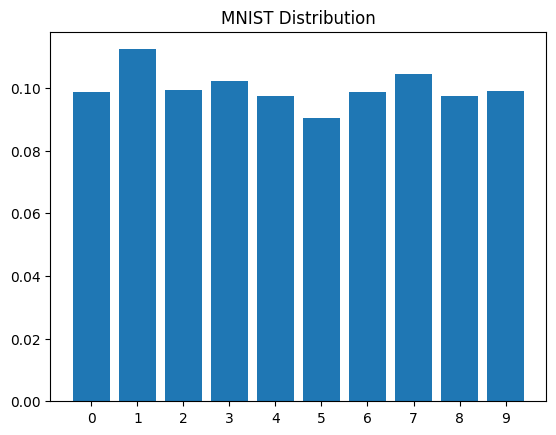

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [69]:
import importlib
import plot_utility
importlib.reload(plot_utility)

desired_distribution = plot_utility.get_distribution(mnist, show_plot=True)
display(desired_distribution)

In [34]:
import evaluator
importlib.reload(evaluator)

<module 'evaluator' from '/Users/Admin/Documents/MachineLearning/project/evaluator.py'>

In [36]:

ev = evaluator.get_MNIST_evaluator(device=gpu)


accuracy = 0.9717999696731567
accuracy = 0.9801999926567078
accuracy = 0.9829999804496765
accuracy = 0.983299970626831
accuracy = 0.9845999479293823
accuracy = 0.9845999479293823
accuracy = 0.9835000038146973
accuracy = 0.9819999933242798
accuracy = 0.9811999797821045
accuracy = 0.9848999977111816


/Users/Admin/Documents/MachineLearning/project/plot_utility.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probability_distribution = evaluator.f(single_image)


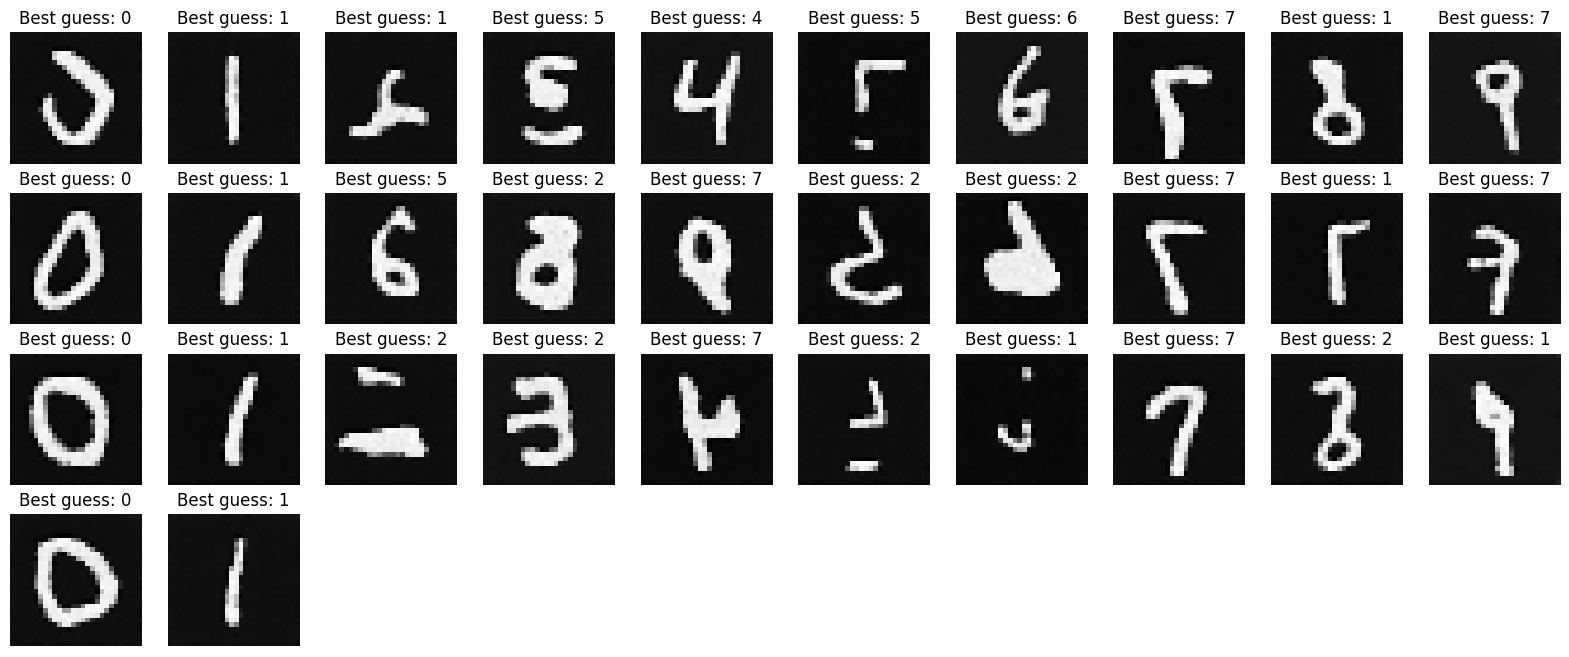

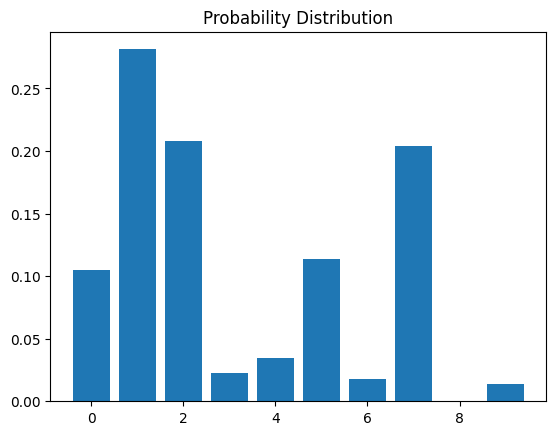

In [74]:
importlib.reload(plot_utility)

actual_distribution = plot_utility.get_classification_distribution(evaluator=ev,
                                                                    input_batch=samples,
                                                                    device=gpu,
                                                                    channels=channels,
                                                                    show_plot=True,
                                                                    image_size=image_size)